In [49]:
# imports


# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
%tensorflow_version 2.x
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.0.0
keras.__version__: 2.2.5


In [0]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [0]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [0]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    return image

In [47]:
### MOUNT YOUR OWN DRIVE HERE...MAKE SURE THE IMAGES ARE HOSTED ON YOUR DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#### USE THIS TO GENERATE THE TRAINING DATA

# !ls
import os
#data_dir = '/Users/brettadlard/OneDrive/UChicago/37011 - Deep Learning/Project/MSCA/37011_Deep_Learning/Project/data'
data_dir = '/content/drive/My Drive/RTIS_Final_Project/Data/augmented'
file_list = os.listdir(data_dir)
image_paths = []
batch_images = []
#steering_angles = np.ndarray(shape=(0,1))
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        #print(filename)
        right = int(filename[-7:-4])  
        left = int(filename[-11:-8])
        steering_angle = left / right * 100
        #newrow = np.array([left,right])
        steering_angles.append(steering_angle)
        image = img_preprocess(my_imread(os.path.join(data_dir,filename)))
        batch_images.append(image)

batch_images = np.asarray(batch_images)

image_path: /content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573655622_300_255.png
steering_Angle: 117.64705882352942


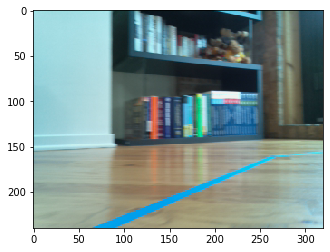

In [55]:
#### CHECK OVER A RANDOM IMAGE
image_index = 750
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: {}".format(steering_angles[image_index]))
df = pd.DataFrame()
df['ImagePath'] = image_paths
#df['left'] = steering_angles[:,0]
#df['right'] = steering_angles[:,1]

In [71]:
#### USE THIS TO CREATE AUGMENTED DATA ####
import os
import random
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from datetime import datetime
from skimage import img_as_ubyte
from time import sleep


def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def zoom(image_array: ndarray):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image_array)
    return image

# dictionary of the transformations we defined earlier
available_transformations = {
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'zoom': zoom
}


folder_path = "/content/drive/My Drive/RTIS_Final_Project/Data/correction"
aug='/content/drive/My Drive/RTIS_Final_Project/Data'
num_files_desired = 150

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


num_generated_files = 0
flip = False
while num_generated_files <= num_files_desired:

    image_path = random.choice(images)
    right = int(image_path[-7:-4])  
    left = int(image_path[-11:-8])

    image_to_transform = sk.io.imread(image_path)
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    if num_transformations_to_apply ==1:
        # random transformation to apply for a single image
        key = 'noise'
    elif num_transformations_to_apply==2: 
        key = 'horizontal_flip'
    else:
        key = 'zoom'
    transformed_image = available_transformations[key](image_to_transform)


    now = datetime.now()
    imageinx = datetime.timestamp(now)
    if key == 'horizontal_flip':
        left = int(image_path[-7:-4])  
        right = int(image_path[-11:-8])
    new_file_path = '%s/augmented/%03d_%03d_%03d.png' % (aug, imageinx, left, right)
    sleep(0.5)
    
    # write image to the disk
 #   io.imsave(new_file_path, transformed_image)
    print(os.path.join(new_file_path))
    io.imsave(os.path.join(new_file_path),img_as_ubyte(transformed_image))
    num_generated_files += 1


/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674178_300_225.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674179_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674180_300_215.png


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674180_215_300.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674181_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674181_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674182_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674183_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674183_215_300.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674184_225_300.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674185_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674186_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674186_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674188_300_215.png
/content/drive/My Drive/RTIS_Final_Project/Data/augmented/1573674188_215_300.png
/content/drive/My Drive/RTIS

In [75]:
X_train, X_test, y_train, y_test = train_test_split(batch_images, np.asarray(steering_angles), test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_test)))

Training data: 1649
Validation data: 413


83.33333333333334


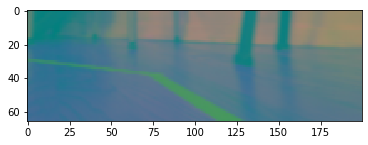

In [59]:
#### VISUALIZE MODIFIED DATA
plt.imshow(X_train[600])
print(y_train[600])

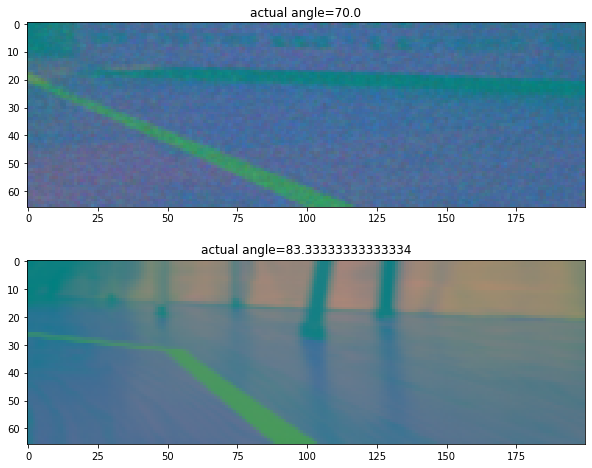

In [76]:
n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_train[i])
    axes[i].set_title(f"actual angle={y_train[i]}") 

In [77]:
### NVIDIA MODEL ###
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.5)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu')) # added 20
    
    # output layer: predict both wheel speeds
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [78]:
### TRAIN THE MODEL ###
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = '/content/drive/My Drive/RTIS_Final_Project'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit(X_train, 
                    y_train,
                    #batch_size=500,
                    epochs=500,
                    validation_split=.2,
                    callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

Train on 1319 samples, validate on 330 samples
Epoch 1/500
1248/1319 [===========================>..] - ETA: 0s - loss: 1884.7677
Epoch 00001: val_loss improved from inf to 530.90113, saving model to /content/drive/My Drive/RTIS_Final_Project/lane_navigation_check.h5
1319/1319 [==============================] - 2s 1ms/sample - loss: 1807.9279 - val_loss: 530.9011
Epoch 2/500
1216/1319 [==========================>...] - ETA: 0s - loss: 501.0002
Epoch 00002: val_loss improved from 530.90113 to 516.08440, saving model to /content/drive/My Drive/RTIS_Final_Project/lane_navigation_check.h5
1319/1319 [==============================] - 1s 440us/sample - loss: 499.1941 - val_loss: 516.0844
Epoch 3/500
1184/1319 [=========================>....] - ETA: 0s - loss: 532.2457
Epoch 00003: val_loss improved from 516.08440 to 464.80079, saving model to /content/drive/My Drive/RTIS_Final_Project/lane_navigation_check.h5
1319/1319 [==============================] - 1s 438us/sample - loss: 526.0439 - val

mse       = 3.8e+01
r_squared = 92.15%



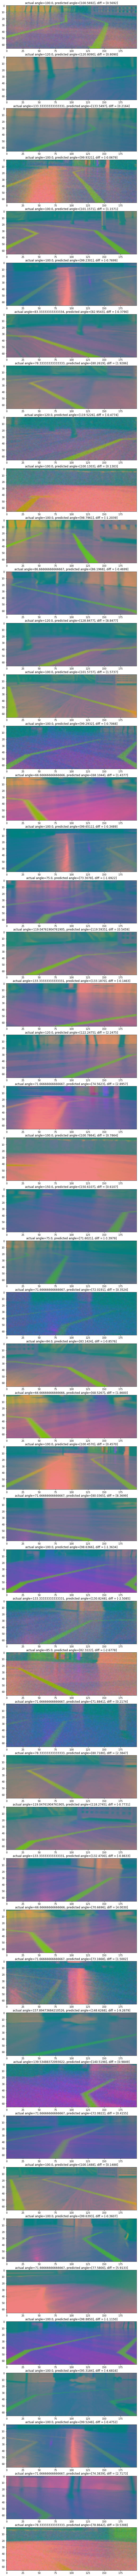

In [80]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    #model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred




y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 50
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={(y_pred[i])}, diff = {(y_pred[i])-y_test[i]}")

In [66]:
Y_pred = model.predict(X_test)
summarize_prediction(y_test,Y_pred)

mse       = 7.5
r_squared = 98.06%

